## Solve IVP using PINN

- Subject: Physics-informed Neural Networks
- Reference:
- created: 2024.11.16

### Problem

Solve an inital value problem:

$$\frac{du}{dt} = \cos(2\pi t),\quad u(0)=1,\quad t\in[0,2]$$

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loss Functions and Data

In [3]:
def u_exact(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

def residual_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = u_t - torch.cos(2 * np.pi * t)
    return torch.mean(residual**2)

## Collocation points (Domain): residual loss
t_np = np.linspace(0, 2, 51)
t = torch.tensor(t_np).float().view(-1, 1).to(device)

## Initial points: initial condition loss
t0 = torch.tensor(0).float().view(-1, 1).to(device)
u0 = torch.tensor(1).float().view(-1, 1).to(device)

## Data points: data loss
n_data = 20
t_data_np = np.linspace(0.25, 1, n_data) + np.random.randn(n_data) * 0.01
u_data_np = u_exact(t_data_np) +  np.random.randn(n_data) * 0.02

t_data = torch.tensor(t_data_np).float().view(-1, 1).to(device)
u_data = torch.tensor(u_data_np).float().view(-1, 1).to(device)

### Modeling and Training

In [7]:
## Model
model = nn.Sequential(
    nn.Linear(1, 20),  nn.Tanh(),
    nn.Linear(20, 20), nn.Tanh(),
    nn.Linear(20, 1),
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training
n_epochs = 10000
model.train()
for epoch in range(1, n_epochs + 1):
    loss_res = residual_loss(model, t)                  # residaul loss
    loss_ic = torch.mean((model(t0) - u0)**2)           # initial condition loss
    loss_data = torch.mean((model(t_data) - u_data)**2) # data loss

    total_loss = loss_res + loss_ic + loss_data

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch[{epoch:5d}/{n_epochs}] total: {total_loss.item():.2e} "
              f"res: {loss_res.item():.2e} ic: {loss_ic.item():.2e} "
              f"data: {loss_data.item():.2e}")

Epoch[ 1000/10000] total: 2.75e-01 res: 2.75e-01 ic: 2.56e-05 data: 5.84e-04
Epoch[ 2000/10000] total: 1.20e-03 res: 8.47e-04 ic: 1.68e-06 data: 3.55e-04
Epoch[ 3000/10000] total: 6.84e-04 res: 3.28e-04 ic: 9.50e-07 data: 3.55e-04
Epoch[ 4000/10000] total: 5.63e-04 res: 2.09e-04 ic: 1.20e-06 data: 3.53e-04
Epoch[ 5000/10000] total: 4.94e-04 res: 1.41e-04 ic: 1.42e-06 data: 3.52e-04
Epoch[ 6000/10000] total: 4.36e-04 res: 8.42e-05 ic: 1.63e-06 data: 3.51e-04
Epoch[ 7000/10000] total: 3.91e-04 res: 3.95e-05 ic: 1.91e-06 data: 3.50e-04
Epoch[ 8000/10000] total: 3.70e-04 res: 1.82e-05 ic: 1.97e-06 data: 3.50e-04
Epoch[ 9000/10000] total: 3.77e-04 res: 1.74e-05 ic: 1.03e-05 data: 3.49e-04
Epoch[10000/10000] total: 3.66e-04 res: 1.33e-05 ic: 2.77e-06 data: 3.50e-04


### Evaluation

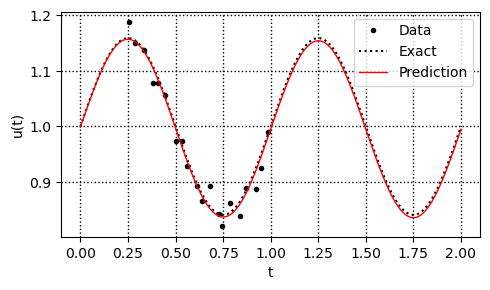

In [8]:
t_test_np = np.linspace(0, 2, 1001)
t_test = torch.tensor(t_test_np).float().view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(t_test)
    u_pred_np = u_pred.cpu().detach().numpy().flatten()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_data_np, u_data_np, 'ko', ms=3, label="Data")
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_test_np, u_pred_np, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()